In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import sys
# import tensorflow_addons as tfa
# from tfa.layers import flatten
%matplotlib inline

In [2]:
training_file = "data/train.pickle"
validation_file= "data/valid.pickle"
testing_file = "data/test.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid[0].shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test.shape)

X_train shape: (32, 32, 3)
y_train shape: (34799,)
X_valid shape: (32, 32, 3)
y_valid shape: (4410,)
X_test shape: (32, 32, 3)
y_test shape: (12630,)


In [3]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

In [4]:
print("Number of training examples = ", n_train)
print("Number of validation example = ", n_valid)
print("Number of testing samples = ", n_test)
print("Shape of first training image = ", image_shape[0], "w x", image_shape[1], "h x", image_shape[2], "d")
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation example =  4410
Number of testing samples =  12630
Shape of first training image =  32 w x 32 h x 3 d
Number of classes =  43


In [5]:
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

rand_train_indices = np.random.randint(0, X_train.shape[0], 10)
rand_valid_indices = np.random.randint(0, X_valid.shape[0], 10)
rand_test_indices = np.random.randint(0, X_test.shape[0], 10)

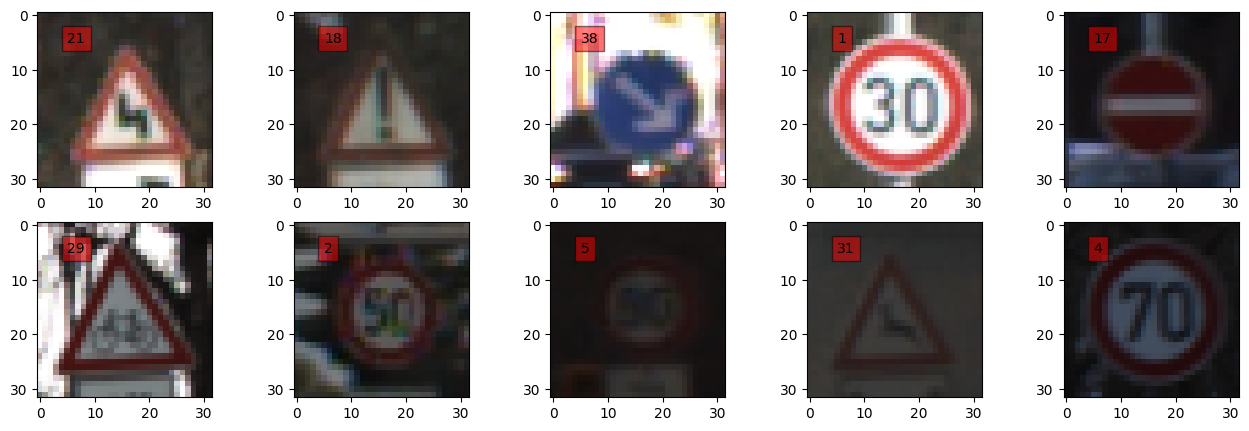

In [6]:
plt.figure(figsize=(16, 5))
for index in range(len(rand_train_indices)):
    sub_plt = plt.subplot(2, 5, index + 1)
    sub_plt.imshow(X_train[rand_train_indices[index]])
    sub_plt.text(5, 5, y_train[rand_train_indices[index]], bbox=dict(facecolor='r', alpha=0.5))

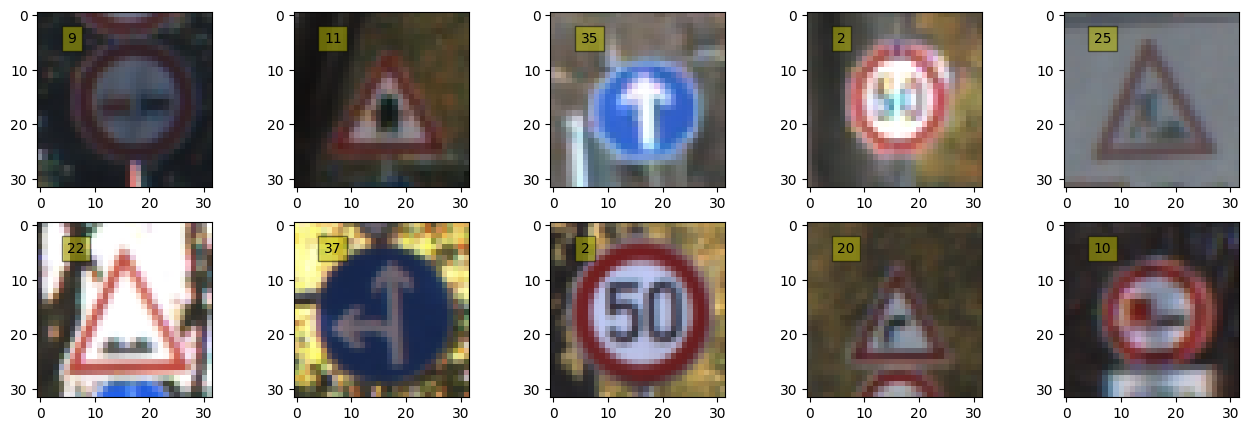

In [7]:
plt.figure(figsize=(16, 5))
for index in range(len(rand_valid_indices)):
    sub_plt = plt.subplot(2, 5, index + 1)
    sub_plt.imshow(X_valid[rand_valid_indices[index]])
    sub_plt.text(5, 5, y_valid[rand_valid_indices[index]], bbox=dict(facecolor='y', alpha=0.5))

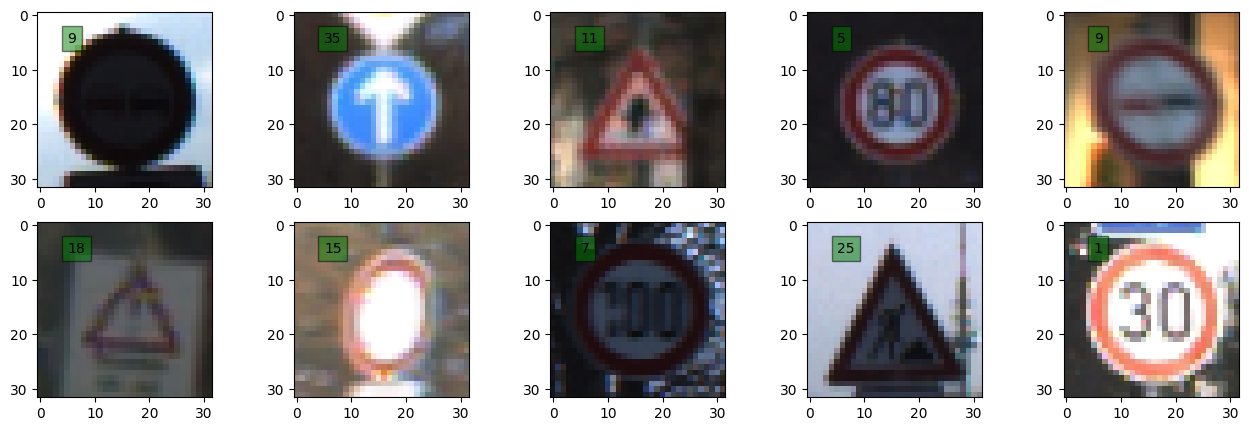

In [8]:
plt.figure(figsize=(16, 5))
for index in range(len(rand_test_indices)):
    sub_plt = plt.subplot(2, 5, index + 1)
    sub_plt.imshow(X_test[rand_test_indices[index]])
    sub_plt.text(5, 5, y_test[rand_test_indices[index]], bbox=dict(facecolor='g', alpha=0.5))

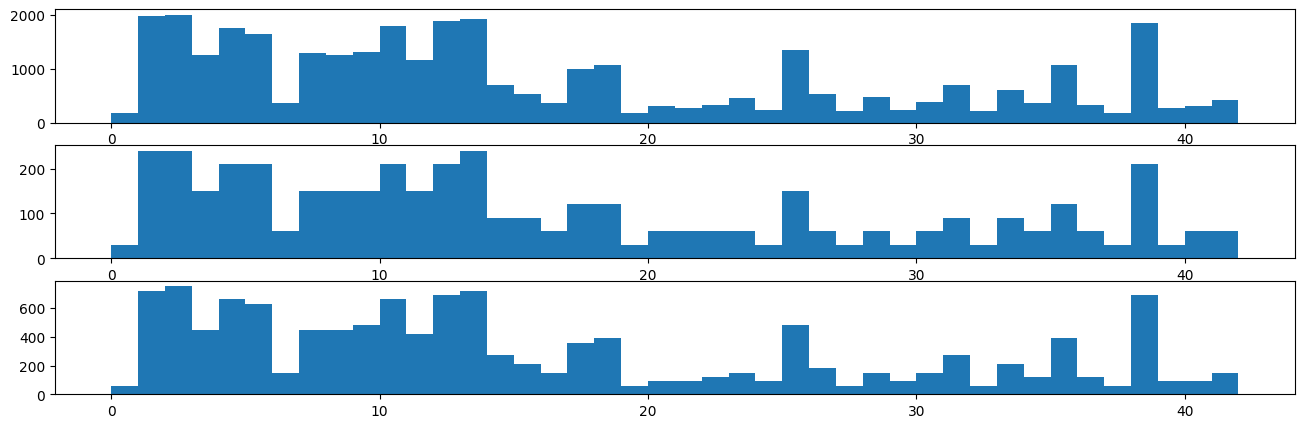

In [9]:
plt.figure(figsize=(16, 5))

sub_plt = plt.subplot(3, 1, 1)
train_hist = sub_plt.hist(y_train, bins=range(y_train.max() + 1))

sub_plt = plt.subplot(3, 1, 2)
valid_hist = sub_plt.hist(y_valid, bins=range(y_valid.max() + 1))

sub_plt = plt.subplot(3, 1, 3)
test_hist = sub_plt.hist(y_test, bins=range(y_test.max() + 1))

In [10]:
rand_train_ind = np.arange(X_train.shape[0])
rand_valid_ind = np.arange(X_valid.shape[0])
rand_test_ind = np.arange(X_test.shape[0])

np.random.shuffle(rand_train_ind)
np.random.shuffle(rand_valid_ind)
np.random.shuffle(rand_test_ind)

X_train = X_train[rand_train_ind].astype(np.float32)
X_valid = X_valid[rand_valid_ind].astype(np.float32)
X_test = X_test[rand_test_ind].astype(np.float32)

y_train = y_train[rand_train_ind]
y_valid = y_valid[rand_valid_ind]
y_test = y_test[rand_test_ind]

In [11]:
X_train = (X_train - 128.0) / 128.0
X_valid = (X_valid - 128.0) / 128.0
X_test = (X_test - 128.0) / 128.0

In [12]:
y_oh_train = np.zeros((y_train.shape[0], y_train.max() + 1), dtype=np.float32)
y_oh_train[np.arange(y_train.shape[0], dtype=np.uint32), y_train] = 1.0

y_oh_valid = np.zeros((y_valid.shape[0], y_valid.max() + 1), dtype=np.float32)
y_oh_valid[np.arange(y_valid.shape[0], dtype=np.uint32), y_valid] = 1.0

y_oh_test = np.zeros((y_test.shape[0], y_test.max() + 1), dtype=np.float32)
y_oh_test[np.arange(y_test.shape[0], dtype=np.uint32), y_test] = 1.0

In [13]:
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import sys

In [14]:
class Cnn5(object):

    def __init__(self, features, filters, dense_size, num_out, nn_scope='CNN_Net'):

        self._filters = filters
        self._dense_size = dense_size
        self._num_out = num_out
        self._nn_scope = nn_scope

        with tf.variable_scope(self._nn_scope):

            self.conv_1 = tf.layers.conv2d(features, filters=self._filters[0], kernel_size=(3, 3),
                                            strides=(1, 1), padding="VALID",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            activation=tf.nn.leaky_relu, name="Conv_1")

            self.conv_2 = tf.layers.conv2d(self.conv_1, filters=self._filters[1], kernel_size=(3, 3),
                                            strides=(1, 1), padding="VALID",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            activation=tf.nn.leaky_relu, name="Conv_2")

            self.maxpool_1 = tf.layers.max_pooling2d(self.conv_2, pool_size=(2, 2), strides=(2, 2), name="MPool_1")

            self.conv_3 = tf.layers.conv2d(self.maxpool_1, filters=self._filters[2], kernel_size=(3, 3),
                                            strides=(1, 1), padding="VALID",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            activation=tf.nn.leaky_relu, name="Conv_3")

            self.conv_4 = tf.layers.conv2d(self.conv_3, filters=self._filters[3], kernel_size=(3, 3),
                                            strides=(1, 1), padding="VALID",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            activation=tf.nn.leaky_relu, name="Conv_4")

            self.maxpool_2 = tf.layers.max_pooling2d(self.conv_4, pool_size=(2, 2), strides=(2, 2), name="MPool_2")


            self.conv_5 = tf.layers.conv2d(self.maxpool_2, filters=self._filters[4], kernel_size=(3, 3),
                                            strides=(1, 1), padding="VALID",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                            activation=tf.nn.leaky_relu, name="Conv_5")

            self.flat = tf.layers.flatten(inputs=self.conv_5, name="Flat_Conv_5")

            self.fc_1 = tf.layers.dense(self.flat, units=self._dense_size[0],
                                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                         bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                         activation=tf.nn.leaky_relu, name="FC_1")

            self.fc_2 = tf.layers.dense(self.fc_1, units=self._dense_size[1],
                                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                         bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                         activation=tf.nn.leaky_relu, name="FC_2")

            self.logits = tf.layers.dense(self.fc_2, units=self._num_out,
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           bias_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name="Logits")

            self.prediction = tf.nn.softmax(self.logits)

            self.output = tf.argmax(self.logits, 1)

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

filters = [16, 24, 48, 64, 128]
dense_size = [384, 256]

with tf.variable_scope('Placeholders'):
    # Lets define the requied placeholders
    features = tf.placeholder(tf.float32, shape=[None] + list(image_shape), name="Features")
    labels = tf.placeholder(dtype=tf.float32, shape=[None] + list(y_oh_train.shape[1:]), name="Labels")
    learning_rate = tf.placeholder(dtype=tf.float32, name="Learning_rate")


# Using these placeholders, lets construct our Neural Network
cnn5 = Cnn5(features, filters, dense_size, labels.shape[1])
# Now lets define the cost
with tf.variable_scope('Cost'):
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=cnn5.logits, labels=labels, name='loss')
    cost_t = tf.reduce_mean(entropy)
# Accuracy may help us evaluate our training better:
with tf.variable_scope('Accuracy'):
    correct_preds = tf.equal(cnn5.output, tf.argmax(labels, 1))
    accuracy_t = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
# Finally define the optimizer:
with tf.variable_scope('Optimizer'):
    optimize_t = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_t)
writer_train = tf.summary.FileWriter("./tensorboard/", graph=tf.get_default_graph())
writer_train.close()

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\1340310773.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  self.conv_1 = tf.layers.conv2d(features, filters=self._filters[0], kernel_size=(3, 3),
C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\1340310773.py:18: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  self.conv_2 = tf.layers.conv2d(self.conv_1, filters=self._filters[1], kernel_size=(3, 3),
C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\1340310773.py:24: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  self.maxpool_1 = tf.layers.max_pooling2d(self.conv_2, pool_size=(2, 2), strides=(2, 2), name="MPool_1")
C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\1340310773.py:26: UserWarning: `tf.layers.conv2d` is d

In [17]:
NUM_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
# Definition of One Epoch of training
def train_epoch(epoch, rate):

    prog_bar = tqdm(desc="Train Epoch %d" % epoch, total=n_train)

    error_list, accuracy_list = [], []
    low, high, step_size, end = 0, n_train + 1, BATCH_SIZE, 0

    for start, end in zip(range(low, high, step_size), range(low + step_size, high, step_size)):
        _, error, accuracy = sess.run([optimize_t, cost_t, accuracy_t],
            feed_dict={features: X_train[start:end],labels: y_oh_train[start:end],learning_rate: rate})

        prog_bar.set_postfix_str("Cost: %f, Acc: %f" % (error, accuracy), refresh=True)
        prog_bar.update(n=BATCH_SIZE)
        error_list.append(error)
        accuracy_list.append(accuracy)

    error = sum(error_list) / len(error_list)
    accuracy = sum(accuracy_list) / len(accuracy_list)
    prog_bar.set_postfix_str("Cost: %f, Acc: %f" % (error, accuracy), refresh=True)
    prog_bar.close()
    sys.stdout.flush()
    return error, accuracy
sess_config = tf.ConfigProto(device_count={'GPU': 1})
sess_config.gpu_options.allow_growth = True
sess = tf.Session(config=sess_config)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

# Start the training
for index in range(NUM_EPOCHS // 2):
    train_epoch(index + 1, LEARNING_RATE)

for index in range(NUM_EPOCHS // 2, NUM_EPOCHS):
    error, accuracy = train_epoch(index + 1, LEARNING_RATE / 2)

saver.save(sess, './saved_models/lane')
sess.close()

print("Final Epoch Cost: %f, Final Epoch Accuracy: %f" %(error, accuracy))

C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\792676403.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  prog_bar = tqdm(desc="Train Epoch %d" % epoch, total=n_train)


Train Epoch 1:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/34799 [00:01<?, ?it/s]

Train Epoch 6:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 7:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 8:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 9:   0%|          | 0/34799 [00:00<?, ?it/s]

Train Epoch 10:   0%|          | 0/34799 [00:00<?, ?it/s]

Final Epoch Cost: 0.007178, Final Epoch Accuracy: 0.997957


In [19]:
def valid_epoch(epoch):

    prog_bar = tqdm(desc="Valid Epoch %d" % epoch, total=n_valid)

    error_list, accuracy_list = [], []
    low, high, step_size, end = 0, n_valid + 1, BATCH_SIZE, 0

    for start, end in zip(range(low, high, step_size), range(low + step_size, high, step_size)):
        error, accuracy = sess.run([cost_t, accuracy_t],
            feed_dict={features: X_valid[start:end],labels: y_oh_valid[start:end]})

        prog_bar.set_postfix_str("Cost: %f, Acc: %f" % (error, accuracy), refresh=True)
        prog_bar.update(n=BATCH_SIZE)
        error_list.append(error)
        accuracy_list.append(accuracy)

    error = sum(error_list) / len(error_list)
    accuracy = sum(accuracy_list) / len(accuracy_list)
    prog_bar.set_postfix_str("Cost: %f, Acc: %f" % (error, accuracy), refresh=True)
    prog_bar.close()
    sys.stdout.flush()
    return error, accuracy
# Start the validation
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))
error, accuracy = valid_epoch(1)
sess.close()
print("Validation Epoch Cost: %f, Validation Epoch Accuracy: %f" %(error, accuracy))

INFO:tensorflow:Restoring parameters from ./saved_models/lane


C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\824994229.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  prog_bar = tqdm(desc="Valid Epoch %d" % epoch, total=n_valid)


Valid Epoch 1:   0%|          | 0/4410 [00:00<?, ?it/s]

Validation Epoch Cost: 0.210173, Validation Epoch Accuracy: 0.956801


In [ ]:
def test_epoch(epoch):

    prog_bar = tqdm(desc="Test Epoch %d" % epoch, total=n_test)

    error_list, accuracy_list = [], []
    low, high, step_size, end = 0, n_test + 1, BATCH_SIZE, 0

    for start, end in zip(range(low, high, step_size), range(low + step_size, high, step_size)):
        error, accuracy = sess.run([cost_t, accuracy_t],
            feed_dict={features: X_test[start:end],labels: y_oh_test[start:end]})

        prog_bar.set_postfix_str("Cost: %f, Acc: %f" % (error, accuracy), refresh=True)
        prog_bar.update(n=BATCH_SIZE)
        error_list.append(error)
        accuracy_list.append(accuracy)

    error = sum(error_list) / len(error_list)
    accuracy = sum(accuracy_list) / len(accuracy_list)
    prog_bar.set_postfix_str("Cost: %f, Acc: %f" % (error, accuracy), refresh=True)
    prog_bar.close()
    sys.stdout.flush()
    return error, accuracy
# Start the testing
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))
error, accuracy = test_epoch(1)
sess.close()
print("Test Epoch Cost: %f, Test Epoch Accuracy: %f" %(error, accuracy))

INFO:tensorflow:Restoring parameters from ./saved_models/lane


C:\Users\ghani\AppData\Local\Temp\ipykernel_4348\3892152692.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  prog_bar = tqdm(desc="Test Epoch %d" % epoch, total=n_test)


Test Epoch 1:   0%|          | 0/12630 [00:00<?, ?it/s]

In [ ]:
import cv2
from glob import glob
import matplotlib.image as mpimg
%matplotlib inline
# Now lets read the image paths from the file system. These images are part of the test dataset of GTSRB.
image_paths = glob('./gtsrb_test_data/*.png')

images = []
for img_path in image_paths:
    img = mpimg.imread(img_path)
    resized_img = cv2.resize(img, (32, 32))
    images.append(resized_img)

# Lets Visualize some random samples from the test dataset
plt.figure(figsize=(16, 5))
for index in range(len(images)):
    sub_plt = plt.subplot(2, 5, index + 1)
    sub_plt.imshow(images[index])

In [ ]:
true_labels = np.array([2, 18, 1, 14, 12, 5, 3, 36, 33, 4])

# Start the testing
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))

[output] = sess.run([cnn5.output], feed_dict={features: images})
sess.close()

print(output)

In [ ]:
accuracy = np.mean(np.equal(true_labels, output)) * 100
print("Performance is %f " % accuracy)

In [ ]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))

top_5_prob = tf.nn.top_k(cnn5.prediction, k=5)

top_prob = sess.run(top_5_prob, feed_dict={features: images})
sess.close()

print(top_prob)

In [ ]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")